# Train CNN with overlays and bandpass

In [25]:
# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape import CNN
from opensoundscape import BoxedAnnotations 

# other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import random
import subprocess
from glob import glob
import sklearn

# set up plotting 
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

### set manual seeds for pytorch and python. useful for debugging, probably don't want to include in actual model training

# Load data

In [26]:
annotations_22 = pd.read_csv("../annotations/rasi_2022_2s_labels.csv")
# annotations_22['file']=annotations_22['file'].str.replace(
#     "/Users/hannahnossan/Documents/Projects/SINE2024/ML_bootcamp/data//",
#     "../data/",
# )
# annotations_22 = pd.read_csv(
#     "/Users/SML161/ecco28_rasi_dialects/labeled_data/rana_sierrae_2022/labels_2s.csv"
# )
# root22 = Path("/Users/SML161/ecco28_rasi_dialects/labeled_data/rana_sierrae_2022/mp3")
# annotations_22["file"] = annotations_22["audio_file"].apply(lambda x: root22 / x)
# annotations_22.drop(columns=["audio_file"], inplace=True)

annotations_24 = pd.read_csv("../annotations/rasi_2024_2s_labels.csv")
# annotations_24['file']=annotations_24['file'].str.replace(
#     "/Users/hannahnossan/Documents/Projects/SINE2024/ML_bootcamp/data//",
#     "../data/",
# )
annotations_23 = pd.read_csv("../data/annotated_detections_2023/rasi_annotated_detections_2023_no_uncertain.csv",index_col=0).drop(columns='index')
annotations_23 = pd.read_csv(
    "../../labeled_data/2023_tdl/rasi_annotated_detections_2023_no_uncertain.csv",
    index_col=0,
).drop(columns="index")


# make relative paths into absolue paths to the audio files
root = "/Users/SML161/ecco28_rasi_dialects/labeled_data/2023_tdl"
annotations_23["file"] = [
    f"{root}/{f}" for f in annotations_23["file"]
]  # practic4e list comprehension!

annotations_22["RA_SI_MU"] = annotations_22[["RASI_C", "RASI_main"]].max(axis=1)
annotations_24["RA_SI_MU"] = annotations_24[["RASI_C", "RASI_main"]].max(axis=1)
annotations_23["RA_SI_MU"] = annotations_23["annotation"]

In [27]:
# concat
labels_df = pd.concat([annotations_22, annotations_23, annotations_24])[
    ["file", "start_time", "end_time", "RA_SI_MU"]
]
labels_df.file.apply(lambda x: Path(x).exists()).all()  # check all files exist

True

In [28]:
labels_df["RA_SI_MU"].value_counts()

RA_SI_MU
0.0    5335
1.0    2024
Name: count, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split

# split into 80% of files for training and 20% for validation
unique_files = labels_df.file.unique()  # make a list of each file
train_files, val_files = train_test_split(
    unique_files, test_size=0.2,random_state=20251205
)  # for each file, put it in the train or validation set
# haven't split up the clips, just the audio files

In [30]:
train_df = labels_df[labels_df["file"].isin(train_files)].set_index(
    ["file", "start_time", "end_time"]
)  # select rows for training if the file is in train_files
val_df = labels_df[labels_df["file"].isin(val_files)].set_index(
    ["file", "start_time", "end_time"]
)  # select rows for training if the file is in val_files
train_df.to_csv('../annotations/train_df_v1.csv')
val_df.to_csv('../annotations/val_df_v1.csv')

# Create CNN object !

In [31]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

architecture = "resnet18"

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)

model = CNN(
    architecture=architecture,
    classes=class_list,
    sample_duration=2,
)

In [32]:
# Check to see if GPU is available on computer
print(f"model.device is: {model.device}")

model.device is: mps


In [33]:
# check to see what percent of training data are negatives
train_df.mean(0)

RA_SI_MU    0.275013
dtype: float64

In [74]:
from opensoundscape import Audio, Spectrogram, CNN, BoxedAnnotations

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,5) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import opensoundscape as opso

In [75]:
model.preprocessor = opso.SpectrogramPreprocessor(sample_duration=2,overlay_df=train_df) # typical mixup
model.preprocessor.pipeline.bandpass.set(min_f=200,max_f=4000)
model.preprocessor.pipeline.overlay.set(overlay_prob=0.5)

In [76]:
model.preprocessor

Preprocessor with pipeline:
load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Augmentation Action calling <function trim_aud...
trim_audio           Action calling <function trim_audio at 0x3054e...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_tensor            Action calling <function Spectrogram.to_image ...
overlay              Augmentation Action calling <function overlay ...
time_mask            Augmentation Action calling <function time_mas...
frequency_mask       Augmentation Action calling <function frequenc...
add_noise            Augmentation Action calling <function tensor_a...
rescale              Action calling <function scale_tensor at 0x305...
random_affine        Augmentation Action calling <function torch_ra...
dtype: object

positives


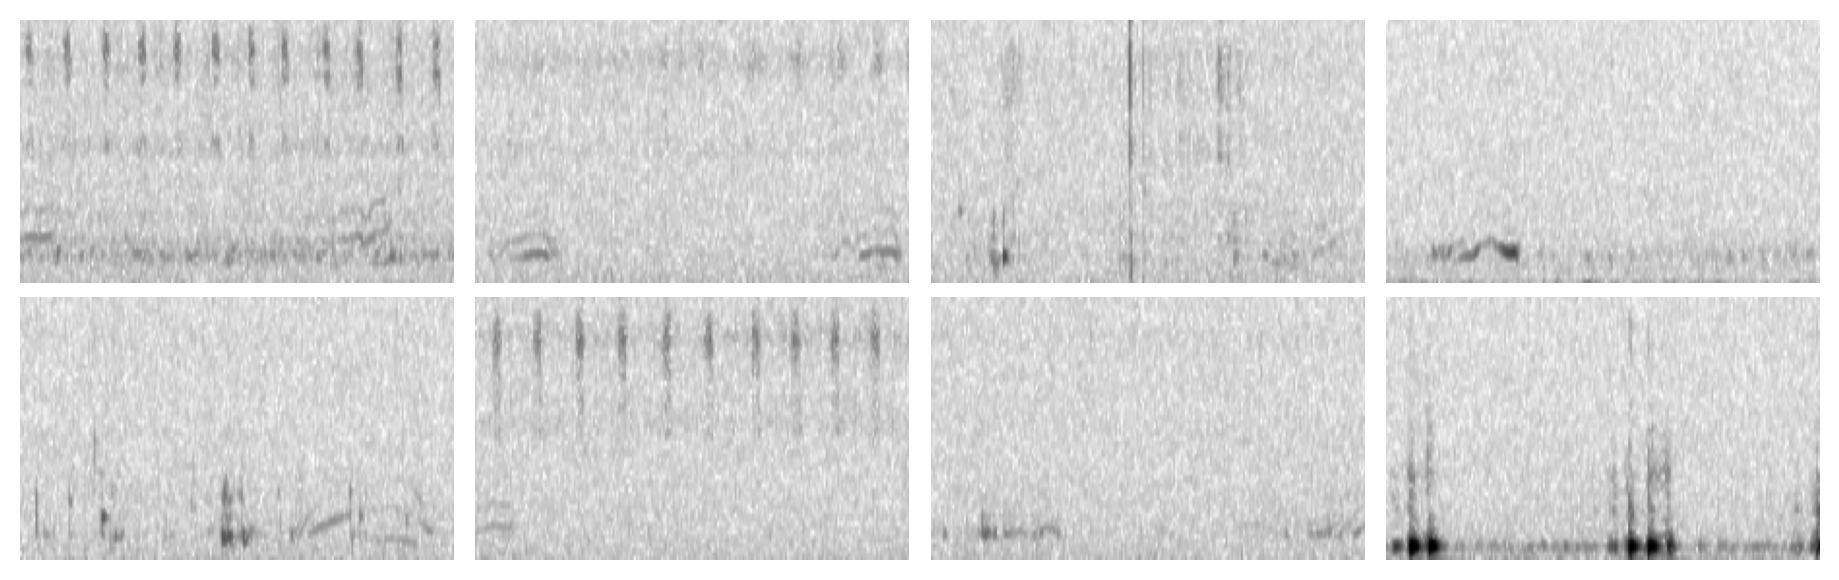

negatives


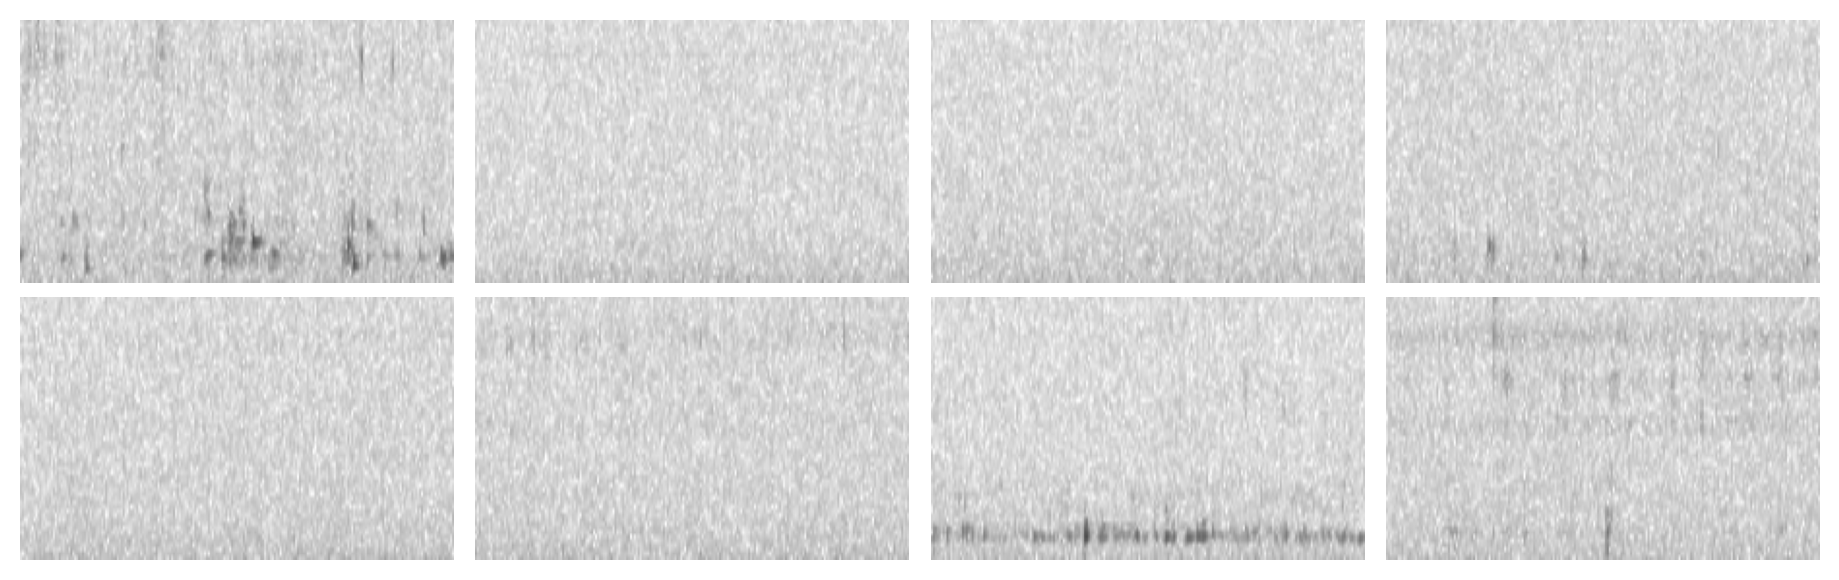

In [77]:
figsize(10,3)
print('positives')
samples = model.generate_samples(train_df[train_df.RA_SI_MU==1].sample(8))
import opensoundscape as opso
opso.preprocess.utils.show_tensor_grid([s.data for s in samples],columns=4)#,labels=[s.labels['RA_SI_MU'] for s in samples])
plt.show()
print('negatives')
samples = model.generate_samples(train_df[train_df.RA_SI_MU==0].sample(8))
import opensoundscape as opso
opso.preprocess.utils.show_tensor_grid([s.data for s in samples],columns=4)#,labels=[s.labels['RA_SI_MU'] for s in samples])
pass

In [78]:
import wandb

try:
    wandb.login()
    wandb_session = wandb.init(
        entity="kitzeslab",  # replace with your entity/group name
        project="RASI_training",
    )
except:  # if wandb.init fails, don't use wandb logging
    print("failed to create wandb session. wandb session will be None")
    wandb_session = None

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


/Users/SML161/miniconda3/envs/opso_dev/lib/python3.13/site-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.13/site-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


In [81]:
# update training_vrs for each round of training
checkpoint_folder = Path("model_checkpts")
training_vrs = Path(f"model_checkpts/{wandb_session.name}")
checkpoint_folder.mkdir(exist_ok=True)
training_vrs.mkdir(exist_ok=True)

In [ ]:
# %%capture --no-stdout --no-display
# Uncomment the line above to silence outputs from this cell

model.train(
    train_df,
    val_df,
    epochs=30,
    batch_size=64,
    log_interval=20,  # log progress every N batches
    num_workers=0,  # parallelized cpu tasks for preprocessing
    wandb_session=wandb_session,
    save_interval=5,  # save checkpoint every N epochs
    save_path=training_vrs,  # location to save checkpoints
)

wandb: WARNING Data passed to `wandb.Image` should consist of values in the range [0, 255], image data will be normalized to this range, but behavior will be removed in a future version of wandb.
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.13/site-packages/wandb/sdk/data_types/image.py:416: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  self._image = pil_image.fromarray(
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.13/site-packages/wandb/sdk/data_types/image.py:416: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  self._image = pil_image.fromarray(
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.13/site-packages/wandb/sdk/data_types/image.py:416: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  self._image = pil_image.fromarray(
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.13/site-packages/wandb/sdk/data_types/imag


Training Epoch 0


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 0 [batch 0/90, 0.00%] 
	Epoch Running Average Loss: 0.955
	Most Recent Batch Loss: 0.955
Epoch: 0 [batch 20/90, 22.22%] 
	Epoch Running Average Loss: 0.753
	Most Recent Batch Loss: 0.560
Epoch: 0 [batch 40/90, 44.44%] 
	Epoch Running Average Loss: 0.619
	Most Recent Batch Loss: 0.368
Epoch: 0 [batch 60/90, 66.67%] 
	Epoch Running Average Loss: 0.543
	Most Recent Batch Loss: 0.354
Epoch: 0 [batch 80/90, 88.89%] 
	Epoch Running Average Loss: 0.521
	Most Recent Batch Loss: 0.358

Validation.


  0%|          | 0/26 [00:00<?, ?it/s]


Training Epoch 1


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 1 [batch 0/90, 0.00%] 
	Epoch Running Average Loss: 0.396
	Most Recent Batch Loss: 0.396
Epoch: 1 [batch 20/90, 22.22%] 
	Epoch Running Average Loss: 0.391
	Most Recent Batch Loss: 0.464
Epoch: 1 [batch 40/90, 44.44%] 
	Epoch Running Average Loss: 0.395
	Most Recent Batch Loss: 0.415
Epoch: 1 [batch 60/90, 66.67%] 
	Epoch Running Average Loss: 0.390
	Most Recent Batch Loss: 0.306
Epoch: 1 [batch 80/90, 88.89%] 
	Epoch Running Average Loss: 0.392
	Most Recent Batch Loss: 0.485

Validation.


  0%|          | 0/26 [00:00<?, ?it/s]


Training Epoch 2


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 2 [batch 0/90, 0.00%] 
	Epoch Running Average Loss: 0.293
	Most Recent Batch Loss: 0.293
Epoch: 2 [batch 20/90, 22.22%] 
	Epoch Running Average Loss: 0.371
	Most Recent Batch Loss: 0.302
Epoch: 2 [batch 40/90, 44.44%] 
	Epoch Running Average Loss: 0.368
	Most Recent Batch Loss: 0.292
Epoch: 2 [batch 60/90, 66.67%] 
	Epoch Running Average Loss: 0.366
	Most Recent Batch Loss: 0.354
Epoch: 2 [batch 80/90, 88.89%] 
	Epoch Running Average Loss: 0.370
	Most Recent Batch Loss: 0.377

Validation.


  0%|          | 0/26 [00:00<?, ?it/s]


Training Epoch 3


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 3 [batch 0/90, 0.00%] 
	Epoch Running Average Loss: 0.323
	Most Recent Batch Loss: 0.323
Epoch: 3 [batch 20/90, 22.22%] 
	Epoch Running Average Loss: 0.374
	Most Recent Batch Loss: 0.361
Epoch: 3 [batch 40/90, 44.44%] 
	Epoch Running Average Loss: 0.378
	Most Recent Batch Loss: 0.416
Epoch: 3 [batch 60/90, 66.67%] 
	Epoch Running Average Loss: 0.373
	Most Recent Batch Loss: 0.416


In [ ]:
# make predictions on validation set
# evaluate low scoring positives, and high scoring negatives